In [1]:
%load_ext autoreload
%autoreload 2

import pygsti
from pygsti.modelpacks import smq1Q_XYI, smq2Q_XYCNOT
import numpy as np
from pprint import pprint
from experiment_helpers import make_depolarized_dataset, run_gst, corrupt_dataset, make_tweaked_dataset
from scipy import linalg as la
import pandas as pd

In [2]:
mp = smq1Q_XYI
target = mp.target_model()
fids = (mp.prep_fiducials(), mp.meas_fiducials())
germs = mp.germs()
maxmaxlen = 64
ds, m_datagen = make_tweaked_dataset(mp, depol_level=0.001, rand_unitary_scale=0.001, max_max_len=maxmaxlen)

In [3]:
fit_mode = 'CPTPLND'

Lpnorm_spec = ('Lp^p', 10)
verb = 4

results = run_gst(ds, fids, germs, target, ['logl', 'normalized tvd', 'tvd', Lpnorm_spec], verbosity=verb, mode=fit_mode)

--- Circuit Creation ---
   952 circuits created
   Dataset has 952 entries: 952 utilized, 0 requested circuits were missing
-- Std Practice:  Iter 1 of 1  (CPTPLND) --: 
    Precomputing CircuitOutcomeProbabilityArray layouts for each iteration.
    Layout for iteration 0
    Num Param Processors (1,)
    MapLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
       1 atoms, parameter block size limits (None,)
    *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
        More atom-processors than hosts: each host gets ~1 atom-processors
        Atom-processors already occupy a single node, dividing atom-processor into 1 param-processors.
    *** Divided 1-host atom-processor (~1 procs) into 1 param-processing groups ***
    Layout for iteration 1
    Num Param Processors (1,)
    MapLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
       1 atoms, parameter block size limits (None,)
    **

      --- Outer Iter 9: norm_f = 141.491, mu=1057.57, |x|=0.0523946, |J|=2328.66
      --- Outer Iter 10: norm_f = 141.49, mu=1166.05, |x|=0.0523309, |J|=2328.87
      --- Outer Iter 11: norm_f = 141.49, mu=2050.66, |x|=0.0523643, |J|=2328.78
      --- Outer Iter 12: norm_f = 141.489, mu=2153.65, |x|=0.052346, |J|=2328.83
      --- Outer Iter 13: norm_f = 141.489, mu=2256.61, |x|=0.0523475, |J|=2328.83
      Least squares message = Both actual and predicted relative reductions in the sum of squares are at most 1e-06
    Sum of Chi^2 = 141.489 (168 data params - 60 (approx) model params = expected mean of 108; p-value = 0.0168947)
    Completed in 0.3s
    Iteration 2 took 0.3s
    
  --- Iterative GST: Iter 3 of 7  285 circuits ---: 
    --- chi2 GST ---
      --- Outer Iter 0: norm_f = 311.393, mu=1, |x|=0.0523475, |J|=3402.26
      --- Outer Iter 1: norm_f = 308.229, mu=4856.95, |x|=0.061184, |J|=3305.72
      --- Outer Iter 2: norm_f = 270.928, mu=1618.98, |x|=0.0532447, |J|=3357.59

/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/objectivefns/objectivefns.py:4055: UserWarning: This derivative is discontinuous and does not return a full subgradient.
  _warnings.warn('This derivative is discontinuous and does not return a full subgradient.')


  --- Outer Iter 3: norm_f = 15.5993, mu=98.0064, |x|=0.0515442, |J|=8849.06
  --- Outer Iter 4: norm_f = 15.4789, mu=32.6688, |x|=0.0511876, |J|=10740.7
  --- Outer Iter 5: norm_f = 15.4365, mu=10.8896, |x|=0.0508289, |J|=7197.58
  --- Outer Iter 6: norm_f = 15.409, mu=7.25974, |x|=0.050839, |J|=18949.8
  --- Outer Iter 7: norm_f = 15.3957, mu=7433.97, |x|=0.0505789, |J|=13428.1
  --- Outer Iter 8: norm_f = 15.3693, mu=2477.99, |x|=0.0505844, |J|=13077.8
  --- Outer Iter 9: norm_f = 15.3649, mu=47577.4, |x|=0.0505742, |J|=17215.9
  --- Outer Iter 10: norm_f = 15.3634, mu=114186, |x|=0.0505784, |J|=81869.3
  --- Outer Iter 11: norm_f = 15.3587, mu=114154, |x|=0.0505777, |J|=70532
  --- Outer Iter 12: norm_f = 15.3539, mu=273971, |x|=0.0505777, |J|=107728
  --- Outer Iter 13: norm_f = 15.3525, mu=164382, |x|=0.050581, |J|=83229.6
  --- Outer Iter 14: norm_f = 15.3507, mu=394518, |x|=0.05058, |J|=71635.8
  --- Outer Iter 15: norm_f = 15.3489, mu=236711, |x|=0.0505776, |J|=64967.4
  --- O

In [4]:
# GST model, fit using logl as the final iteration
logl_est = results.estimates['logl']
final_logl_model = logl_est.models['stdgaugeopt']
# GST model, fit using Lp^p for the final iteration
Lp_est_name = str(Lpnorm_spec)
Lp_est = results.estimates[Lp_est_name]
final_LpP_model = Lp_est.models['stdgaugeopt']
# data generating model.
results.estimates['datagen'] = logl_est.copy()
to_replace = [k for k in results.estimates['datagen'].models.keys() if k != 'target' ]
m_datagen.convert_members_inplace(fit_mode)
for k in to_replace:
    results.estimates['datagen'].models[k] = m_datagen



In [5]:
repdata  = ds.repData
cirindex = ds.cirIndex
empiri_probs = []
mprobs_logl = []
mprobs_LpP  = []
for circ, indices in cirindex.items():
    counts = repdata[indices]
    empirical_probs = counts / np.sum(counts)
    empiri_probs.append(empirical_probs)
    model_probs_LpP = np.array(list(final_LpP_model.probabilities(circ).values()))
    mprobs_LpP.append(model_probs_LpP)
    model_probs_logl = np.array(list(final_logl_model.probabilities(circ).values()))
    mprobs_logl.append(model_probs_logl)
empiri_probs = np.array(empiri_probs)
mprobs_logl = np.array(mprobs_logl)
mprobs_LpP = np.array(mprobs_LpP)


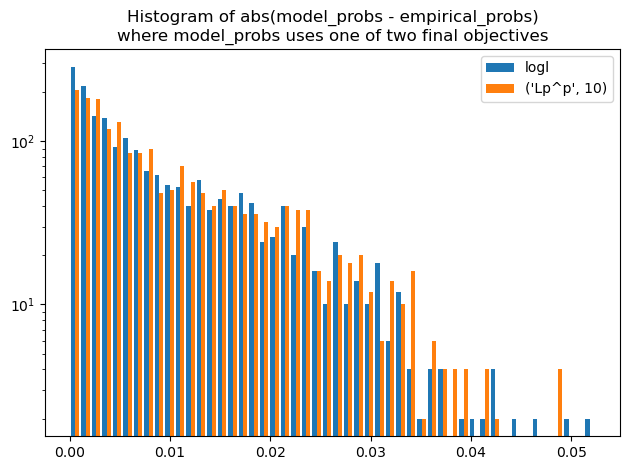

In [6]:
from matplotlib import pyplot as plt
bins = 100
x = np.array([empiri_probs.ravel(), mprobs_logl.ravel(), mprobs_LpP.ravel()]).T
bins = 50
x2 = x[:,1:3].copy()
x2[:,0] = np.abs(x2[:,0] - x[:,0])
x2[:,1] = np.abs(x2[:,1] - x[:,0])
plt.hist(x2, bins=bins)
plt.legend(['logl', Lp_est_name ])
plt.yscale('log')
plt.title('Histogram of abs(model_probs - empirical_probs)\nwhere model_probs uses one of two final objectives')
plt.tight_layout()
plt.show()

In [7]:
Nsigs = []
from pygsti.report.plothelpers import rated_n_sigma
circuitlist = list(ds.cirIndex.keys())
pvecs = []
objectives = []
for estname, est in results.estimates.items():
    model = est.models['stdgaugeopt']
    Nsig, _ = rated_n_sigma(ds, model, circuitlist, 'logl')
    Nsigs.append(Nsig)
    objective = est.final_objective_fn()
    objectives.append(objective)
    pvecs.append(est.models['final iteration estimate'].to_vector())


objvals = np.zeros((len(pvecs),len(objectives)-1))
for i,pvec in enumerate(pvecs):
    for j,objective in enumerate(objectives[:-1]):
        val = objective.fn(pvec, stateless=True)
        if val < 1e-8:
            val = val ** 0.1
        objvals[i,j] = val
objvals = np.concatenate((objvals, np.array(Nsigs).reshape(-1,1)), axis=1)

df = pd.DataFrame(
    objvals,
    index=['m_logl', 'm_{ntvd}', 'm_tvd', 'm_{L_{10}^10}', 'm_datagen'],
    columns=['LogL(m)', 'nTVD(m)', 'TVD(m)', 'L_{10}(m)', 'N_{\sigma}']
)

print(df)

                    LogL(m)     nTVD(m)      TVD(m)   L_{10}(m)  N_{\sigma}
m_logl         4.675041e+02   16.335460    8.786676    0.058305    0.326392
m_{ntvd}       5.000476e+02   15.342389    8.720995    0.058255    1.842914
m_tvd          4.842252e+02   15.826993    8.657254    0.058421    1.105592
m_{L_{10}^10}  6.381221e+02   17.786360    9.578566    0.056057    8.277176
m_datagen      1.833490e+06  835.190192  467.173129  126.554588    0.878730
